# Определение возраста покупателей

## Описание проекта

**Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей.**

## Ход проекта

* **Знакомство с данными**
* **Обучение моделей**
* **Вывод**

## Цель проекта

* **Определить возраст покупателя по фотографии и на основе предсказания сети анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы, а также контролировать добросовестность кассиров при продаже алкоголя.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import seaborn as sns
import numpy as np
import pandas as pd

## Исследовательский анализ данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.shape

(7591, 2)

**7591 фотографий с указанием реального возраста.**

**Для задачи регрессии данных довольно мало, нужно использовать аугментацию данных для увеличения выборки.**

In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


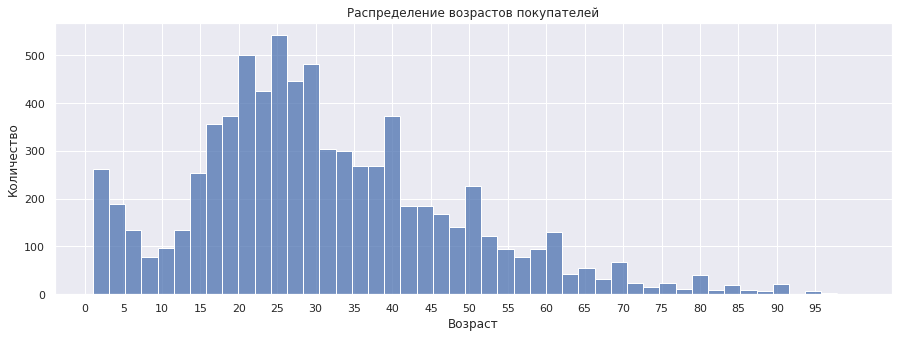

In [5]:
sns.set(rc={'figure.figsize':(15,5)})
plot = sns.histplot(labels.real_age)
plot.set_title('Распределение возрастов покупателей')
plot.set(xticks=np.arange(0,100,5))
plot.set_xlabel('Возраст')
plot.set_ylabel('Количество');

**В целом распределение возрастов имеет вид нормального распределения, есть небольшие выбросы, особенно выделяется спад в возрасте 7-13 лет, может быть обусловленно демографической ямой**

**Выведем на экран случайный набор фотографий из нашего сета**

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345);

Found 7591 validated image filenames.


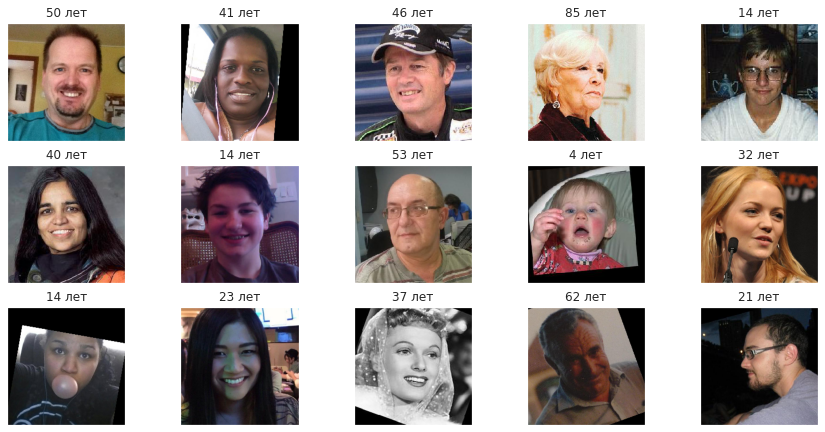

In [7]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(15,10))
for i in range(15):
    fig.add_subplot(4, 5, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]} лет')
    plt.xticks([])
    plt.yticks([])

### Промежуточный вывод

* **В датасете более 7 тысяч фотографий с указанием возраста**
* **Возраст людей на фотографиях имеет нормальное распределение с небольшим спадом в районе 7-13лет**

* **Изображения представляют из себя фотографии лиц крупным планом, основная масса трёхканальные RGB, но присутствуют и одноканальные - черно-белые фотографии.**
* **Подобная картина соотношений и с направлением лица, большинство фоторгафий содержат анфас лица, но встречаются также и лица в профиль.**

## Обучение модели

In [8]:
# Подготовка тренировачных данных
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)
        
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        subset='training',
        target_size=(224, 224),
        horizontal_flip=True,
        batch_size=16,
        class_mode='raw'
        )
    return train_datagen_flow

In [9]:
# Подготовка тестовых данных
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    val_datagen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        subset='validation',
        target_size=(224, 224),
        batch_size=16
    )
    return val_datagen_flow

In [10]:
# Создание нейросети
def create_model(shape):
    optimizer=Adam(learning_rate=0.0005)
    backbone = ResNet50(input_shape=(150, 150, 3),
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False) 
    model = keras.Sequential()
    model.add(backbone)
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae']
    )
    return model

In [11]:
# Обучение нейросети
def train_model(model, train_data, test_data, 
                batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
             validation_steps=validation_steps, 
              verbose=2, shuffle=True)
    return model

In [12]:
# Логи обучения.
"""<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-12-14 04:56:40.960766: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-12-14 04:56:41.241483: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 47s - loss: 213.1070 - mae: 11.1616 - val_loss: 443.8044 - val_mae: 16.0052
Epoch 2/10
356/356 - 38s - loss: 126.6800 - mae: 8.6257 - val_loss: 281.8344 - val_mae: 12.8484
Epoch 3/10
356/356 - 38s - loss: 95.8159 - mae: 7.5188 - val_loss: 118.0985 - val_mae: 8.2429
Epoch 4/10
356/356 - 38s - loss: 62.1073 - mae: 6.0726 - val_loss: 122.3137 - val_mae: 8.2066
Epoch 5/10
356/356 - 38s - loss: 41.5974 - mae: 4.9857 - val_loss: 102.6533 - val_mae: 7.6487
Epoch 6/10
356/356 - 38s - loss: 34.1210 - mae: 4.5181 - val_loss: 95.1566 - val_mae: 7.2806
Epoch 7/10
356/356 - 38s - loss: 24.0929 - mae: 3.7753 - val_loss: 102.1068 - val_mae: 7.6883
Epoch 8/10
356/356 - 38s - loss: 21.2017 - mae: 3.5256 - val_loss: 98.4983 - val_mae: 7.3833
Epoch 9/10
356/356 - 38s - loss: 19.4437 - mae: 3.3917 - val_loss: 101.6357 - val_mae: 7.7483
Epoch 10/10
356/356 - 38s - loss: 18.3130 - mae: 3.2680 - val_loss: 85.4943 - val_mae: 6.9877
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 85.4943 - mae: 6.9877
Test MAE: 6.9877""";

## Анализ обученной модели

* **Сверточная нейронная сеть Resnet50 в 50 слоёв с алгоритмом оптимизации Adam, с добавлением нескольких полносвязных слоёв**
* **Время обучения 20 минут**
* **Средняя абсолютная ошибка при определении возраста 7 лет**

**Модель обучалась на малом датасете в 10 эпох, и за короткий промежуток времени, ошибка при определении возраста довольно высокая что-бы относительно её выводов принимать какие-либо решения.**

## Вывод

**Средняя абсолютная ошибка при определении возраста слишком велика (7лет), при более скурпулёзном выборе слоёв, обучении на большем датасете и более продолжительное время, могут весьма сильно уменьшить ошибку, вероятно тогда сеть годилась бы для определения возрастов покупателей.**